In [33]:
%load_ext autoreload
%autoreload 2

In [66]:
import torch
import json
from sklearn.metrics import r2_score, root_mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from pipeline.walkforward import WFCVGenerator
from config.config_types import AppConfig
from utils.paths import CONFIG_DIR, VOL_EXPERIMENTS_DIR, DATA_DIR, PRICE_EXPERIMENTS_DIR
from models import create_model 


## OLS

In [65]:

# fix a fold
fold = 0
name = "exp_001_mlp_40_sliding"


# -------- load config --------
#cfg = yaml.safe_load(open(CONFIG_DIR / "debug.yaml"))
base = f"{VOL_EXPERIMENTS_DIR}/{name}/trial_20251021_234311/fold_{fold:03d}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)

print(cfg.experiment)
print(cfg.walkforward)

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)
test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):
    if i > 0:
        break

    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data

ExperimentConfig(name='mlp_40_sliding', hyperparams_search=False, monitor='val_loss', mode='min', type='volatility', n_trials=20, random_state=1234)
WFConfig(target_col='var', lookback=5, ratio_train=3, ratio_val=1, ratio_test=1, step=251, lags=40, max_folds=None, scale=True)


In [67]:
X_tr, y_tr, X_val, y_val, X_test, y_test = data[fold] 

for arr in data[fold]:
    print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {np.min(arr):.4f}, {np.max(arr):.4f}")

-0.0000, 1.0000, -4.5377, 589.5318
0.0000, 1.0000, -4.4766, 589.5318
-0.1858, 0.3289, -1.5956, 30.2288
-0.0854, 0.2073, -1.5864, 29.8369
-0.2329, 0.2119, -0.9838, 24.5945
-0.1029, 0.1577, -0.3427, 24.2761


In [68]:


import statsmodels.api as sm


X_tr_const = sm.add_constant(X_tr)
X_te_const = sm.add_constant(X_test)
results = []
for j in range(y_tr.shape[1]):
    res = sm.OLS(y_tr[:, j].squeeze(), X_tr_const).fit()
    results.append(res)
    print(f"\n=== Target {j} ===")
    print(f"Rsq: {res.rsquared:.5f}")
    #print(res.summary())



=== Target 0 ===
Rsq: 1.00000

=== Target 1 ===
Rsq: 1.00000

=== Target 2 ===
Rsq: 1.00000

=== Target 3 ===
Rsq: 1.00000

=== Target 4 ===
Rsq: 1.00000

=== Target 5 ===
Rsq: 0.00287


In [ ]:
# create model
hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
output_shape = cfg.walkforward.lookback+1
ckpt_path = f"{base}model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")
state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
model = create_model(cfg.model, input_shape, output_shape)

model.to("cuda").eval()
y_pred_nn = model(torch.as_tensor(X_test, dtype=torch.float32, device="cuda")).cpu().detach()


for dim in tqdm(range(y_test.shape[1])):

    y_tr_dim = y_tr[:,dim]
    y_pred_ols = results[dim].predict(X_tr_const)
    y_pred_nn_dim = y_pred_nn[:,dim]

    print(y_tr_dim.shape)
    print(y_pred_nn_dim.shape)

    rmse_ols = root_mean_squared_error(y_tr_dim, y_pred_ols)
    rmse_nn  = root_mean_squared_error(y_tr_dim, y_pred_nn_dim)

    r2_ols = r2_score(y_tr_dim, y_pred_ols)
    r2_nn = r2_score(y_tr_dim, y_pred_nn_dim)
    print(f"Rsq ols = {r2_ols:.4f}")
    print(f"Rsq nn = {r2_nn:.4f}")
    print(f"RMSE ols = {rmse_ols:.4f}")
    print(f"RMSE nn = {rmse_nn:.4f}")
    

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 88.15it/s]

(352246,)
torch.Size([352246])
Rsq ols = 1.0000
Rsq nn = -0.0037
RMSE ols = 0.0000
RMSE nn = 1.0018
(352246,)
torch.Size([352246])
Rsq ols = 1.0000
Rsq nn = -0.0087
RMSE ols = 0.0000
RMSE nn = 1.0043
(352246,)
torch.Size([352246])
Rsq ols = 1.0000
Rsq nn = 0.0101
RMSE ols = 0.0000
RMSE nn = 0.9949
(352246,)
torch.Size([352246])
Rsq ols = 1.0000
Rsq nn = 0.0040
RMSE ols = 0.0000
RMSE nn = 0.9980
(352246,)
torch.Size([352246])
Rsq ols = 1.0000
Rsq nn = -0.0062
RMSE ols = 0.0000
RMSE nn = 1.0031
(352246,)
torch.Size([352246])
Rsq ols = 0.0029
Rsq nn = -0.0047
RMSE ols = 0.9986
RMSE nn = 1.0023


(104916,)
(104916,)
R² = 0.0421


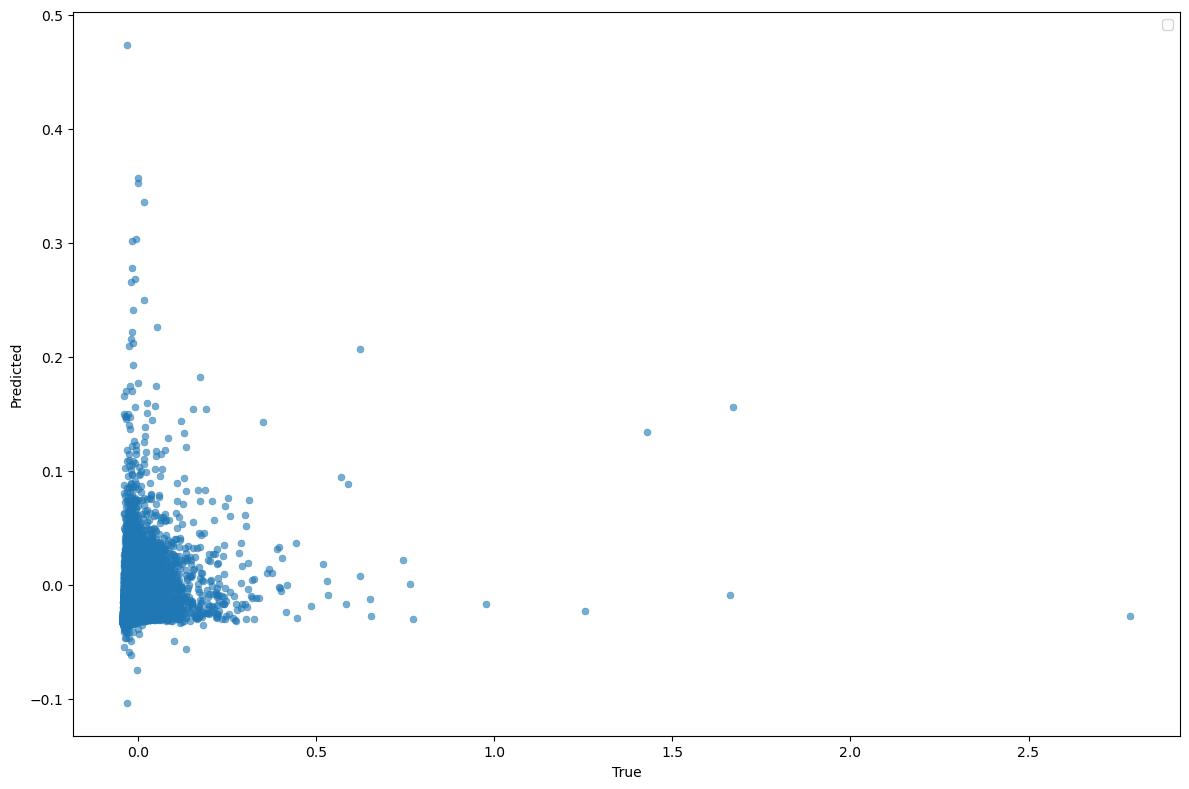

In [ ]:


#plt.figure(figsize=(12,8))
#sns.scatterplot(x=y_test_dim, y=y_pred_ols, s=25, alpha=0.6, edgecolor=None)
#plt.xlabel("True")
#plt.ylabel("Predicted")
#plt.legend()
#plt.tight_layout()
#plt.show()


## Ridge

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import statsmodels.api as sm

# fix a fold
fold = 0

X_tr, y_tr, X_val, y_val, X_test, y_test = data[fold] 

X_tr_const = sm.add_constant(X_tr)
X_test_const = sm.add_constant(X_test)

# --- Define ridge regression (alpha = λ penalty strength) ---
ridge = Ridge(alpha=2, fit_intercept=False)  # intercept already added
ridge.fit(X_tr_const, y_tr)

y_pred_tr_ridge = ridge.predict(X_tr_const)
y_pred_te_ridge = ridge.predict(X_test_const)

r2_train = r2_score(y_tr, y_pred_tr_ridge)
r2_test = r2_score(y_test, y_pred_te_ridge)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_te_ridge))

print(f"R² train: {r2_train:.4f}, R² test: {r2_test:.4f}, RMSE test: {rmse_test:.6f}")

# --- View coefficients (with names if available) ---
coef_names = ["const"] + [f"x{i}" for i in range(X_tr.shape[1])]
for name, coef in zip(coef_names, ridge.coef_):
    print(f"{name:<8} {coef: .6f}")


R² train: 0.0039, R² test: -0.0009, RMSE test: 0.017148
const     0.000164
x0       -0.011912
x1       -0.021484
x2       -0.014487
x3        0.000905
x4        0.018593
x5        0.001307
x6       -0.009751
x7        0.017093
x8        0.012476
x9       -0.001647
x10      -0.016219
x11       0.005134
x12      -0.009627
x13       0.003002
x14      -0.016510
x15      -0.009729
x16      -0.000130
x17       0.003096
x18      -0.034467
x19       0.007574


In [8]:
y_pred_te_ridge

array([ 0.0016495 , -0.00147688, -0.00140913, ...,  0.00043309,
       -0.00088581, -0.00061385], shape=(115175,))

R² = -0.0009


/tmp/ipykernel_2296795/2978607550.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


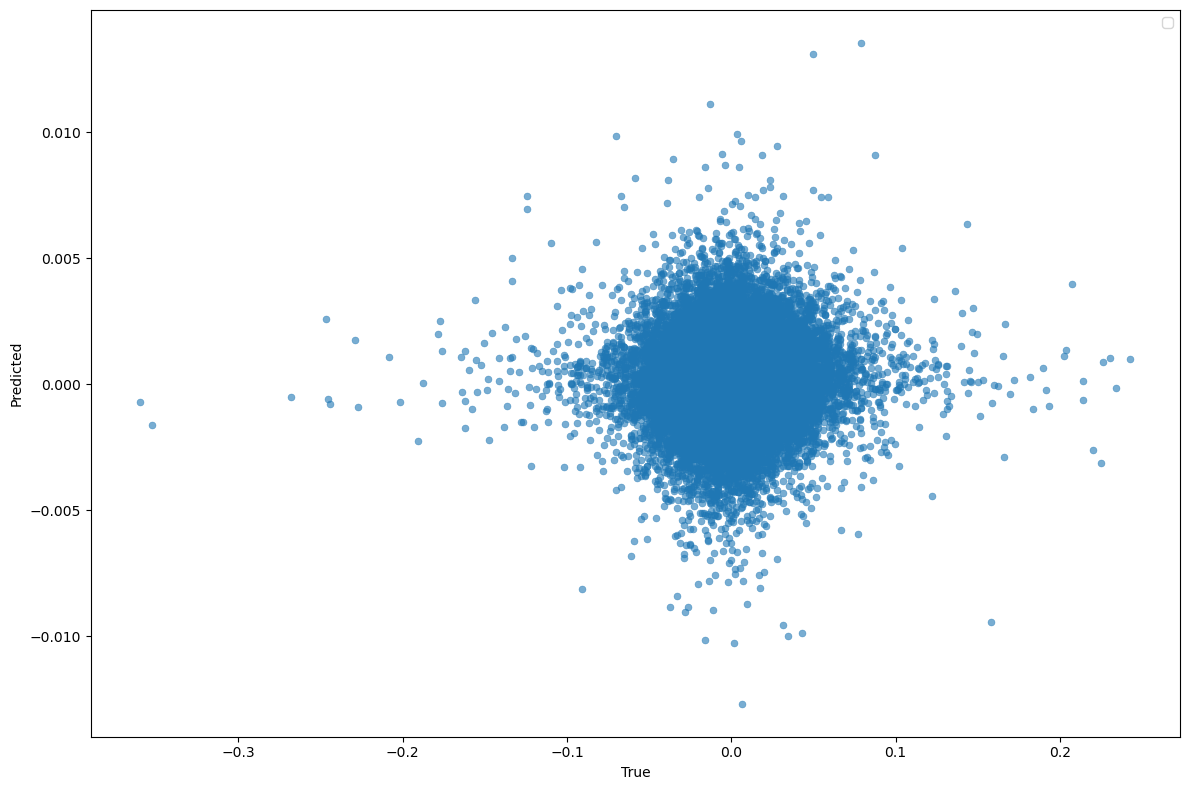

In [9]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_te_ridge)
print(f"R² = {r2:.4f}")

plt.figure(figsize=(12,8))
sns.scatterplot(x=y_test, y=y_pred_te_ridge, s=25, alpha=0.6, edgecolor=None)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()
plt.show()


## ARIMA